In [1]:
"""
Main program implementing reinforcement learning for anomaly detection in KDD NSL Dataset
Author @hari.koduvely
Date Jan 2018
"""

'\nMain program implementing reinforcement learning for anomaly detection in KDD NSL Dataset\nAuthor @hari.koduvely\nDate Jan 2018\n'

In [1]:
import sys
import os

In [3]:
import gym
import gym_network_intrusion
env = gym.make('network-intrusion-v0')
%reload_ext autoreload
%autoreload 2

WARN: Environment '<class 'gym_network_intrusion.envs.network_intrusion_env_1.NetworkIntrusionEnv'>' has deprecated methods. Compatibility code invoked.


In [4]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
# 1. Specify the NN Architecture
n_inputs = 226 # == env.observation_space.shape[0]
n_hidden = 10
n_outputs = 1 # prob of accelerating left
initializer = tf.contrib.layers.variance_scaling_initializer()

# 2. Build the NN
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
logits = fully_connected(hidden, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

#3. Select a random action based on the estimated probabilities
p_yes_and_no = tf.concat(values=[outputs, 1 - outputs], axis=1)
action = tf.multinomial(tf.log(p_yes_and_no), num_samples=1)

init=tf.global_variables_initializer()

In [6]:
# Setting up the training of the NN Using Policy Gradient
y = 1.0 - tf.to_float(action) # target probability is 1 when action is 0 and 0 when action is 1
learning_rate = 0.01
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32)
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#Function to compute the total discounted rewards given the raw rewards
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + discount_rate * cumulative_rewards
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [7]:
"""
n_iterations = 250 # number of training iterations
n_max_steps = 1000 # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 10 # save the model every 10 training iterations
discount_rate = 0.95
"""
n_iterations = 10 # number of training iterations
n_max_steps = 100 # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 10 # save the model every 10 training iterations
discount_rate = 0.95

In [8]:
# Executing the graph
t_start = time.time()
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = [] # all raw rewards for the current episode
            current_gradients = [] # all gradients from the current episode
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: np.array(list(obs)).reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
            # Perform a Policy Update after running the policy for 10 episodes
            all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
            feed_dict = {}
            for var_index, grad_placeholder in enumerate(gradient_placeholders):
                # Multiply the gradients by the action scores and compute the mean
                mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                         for game_index, rewards in enumerate(all_rewards)
                                         for step, reward in enumerate(rewards)], axis=0)
                feed_dict[grad_placeholder] = mean_gradients
                
            sess.run(training_op, feed_dict=feed_dict)
            if iteration % save_iterations == 0:
                # save_path = saver.save(sess, '/Users/harikoduvely/Projects/RL/DataSets/NSL_KDD_CKPT/nsl_kdd_qlearning_4.ckpt')
                save_path = saver.save(sess, 'datasets/nsl_kdd_qlearning_1.ckpt')

t_end = time.time()
print("Traning Time: " + str(t_end - t_start) + "Secs")

Traning Time: 389.334667921Secs


In [10]:
# Evaluation of the results
n_max_steps = 1000
o_list = []
p_list = []
a_list = []
y_list = []
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'datasets/nsl_kdd_qlearning_1.ckpt')
    # load test dataset into a Pandas DataFrame
    df = pd.read_pickle('datasets/kdd_nsl_train_onehot_string.pkl')
    init.run()
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for step in range(n_max_steps):
        obs = df.iloc[step]['s']
        y = df.iloc[step]['y']
        outputs = logits.eval(feed_dict={X: np.array(list(obs)).reshape(1, n_inputs)})
        p_yes_and_no = tf.concat(values=[outputs, 1 - outputs], axis=1)
        py = p_yes_and_no.eval()
        action = tf.multinomial(tf.log(p_yes_and_no), num_samples=1)
        act = action.eval()
        o_list.append(obs)
        p_list.append(py[0][0])
        a_list.append(act[0][0])
        y_list.append(y) 
        
    df_pred = pd.DataFrame({'obs':o_list,'pred':p_list, 'action':a_list, 'y':y_list})
    # Saving the dataframe to a pickle file in directory DataSets
    df_pred.to_pickle('datasets/kdd_nsl_train_results.pkl')

INFO:tensorflow:Restoring parameters from datasets/nsl_kdd_qlearning_1.ckpt


In [12]:
df_pred = pd.read_pickle('datasets/kdd_nsl_train_results.pkl')

In [13]:
lam = 0.1 * np.arange(10)

In [14]:
def generate_roc(df):
    lamda = 0.1 * np.arange(10)
    tpl = []
    fpl = []
    tnl = []
    fnl = []
    prl = []
    rel = []
    frl = []
    for lam in lamda:
        tp = 0.0
        fp = 0.0
        tn = 0.0
        fn = 0.0
        for i in range(df.shape[0]):
            p = df.iloc[i]['pred']
            y = df.iloc[i]['y']
            y = y.astype(int)
            if  y==1 and p>=lam:
                tp += 1.0
            elif y==1 and p<lam:
                fn += 1.0
            elif y==-1 and p>=lam:
                fp += 1.0
            elif y==-1 and p<lam:
                tn += 1.0
        pr = tp/(tp + fp + 1.0)
        re = tp/(tp + fn + 1.0)
        fpr = fp/(tn + fp + 1.0)
        tpl.append(tp)
        fpl.append(fp)
        tnl.append(tn)
        fnl.append(fn)
        prl.append(pr)
        rel.append(re)
        frl.append(fpr)
    df_lam = pd.DataFrame({'lam': lamda, 'TP': tpl, 'FP': fpl, 'TN': tnl, 'FN': fnl, 'Precision': prl, 'Recall': rel, 'FPR':frl})
    return df_lam

In [15]:
df_in = df_pred.drop(['action','obs'], axis=1)

In [16]:
df_lam = generate_roc(df_in)

In [17]:
plt.plot(df_lam['FPR'],df_lam['Recall'])

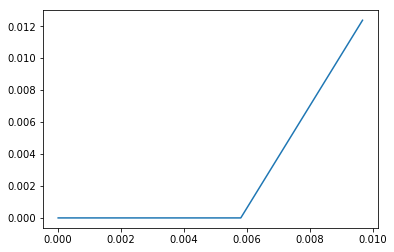

In [18]:
plt.show()